In [12]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Data source import complete.')


Data source import complete.


In [13]:
!mkdir -p dataset
!kaggle datasets download -d msambare/fer2013 -p dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 58% 35.0M/60.3M [00:00<00:00, 196MB/s] 
100% 60.3M/60.3M [00:00<00:00, 205MB/s]


# 📖 Introduction

The goal of this project is to develop a deep learning model that can accurately classify facial expressions into one of seven categories: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral. We will use convolutional neural networks (CNNs) to train our model, as they have been shown to be effective in image classification tasks. Our approach involves training a CNN model from scratch on the FER-2013 dataset

![emotions.png](attachment:02a21be9-12eb-4595-a450-8414036bac30.png)



# 💾 Data

The FER-2013 dataset consists of 48x48 pixel grayscale images of faces that have been automatically registered to be centred and occupy a similar amount of space in each image. The dataset contains 24,400 images, with 22,968 examples in the training set and 1,432 examples in the public test set.

# 🛠 Preprocessing

In this section, we will be using both data generators and data augmentation to train a deep learning model for human emotion detection using the FER-2013 dataset. Due to the size and complexity of the dataset, it would be impractical to load all of the images into memory at once. Therefore, we will be using data generators to generate batches of images on-the-fly during training, which will allow us to efficiently train our model on the entire dataset.

In addition, we will be applying various data augmentation techniques to the training images, such as rotation, shifting, and flipping. This will help to increase the size and diversity of our training set, which can improve the performance of our deep learning model. By introducing variability into the training process, data augmentation can also help to prevent overfitting, which occurs when the model becomes too closely tailored to the training set and performs poorly on new, unseen data.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [15]:
train_dir = "./dataset/train"
test_dir = "./dataset/test"


In [16]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

In [17]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training"              # Uses the training subset of the data
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation"            # Uses the validation subset of the data
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


# Modeling

## CNN Model

To develop the CNN architecture, we will begin by defining the input layer and the number of filters in the first convolutional layer. Then, we will add additional convolutional layers with increasing numbers of filters, followed by max-pooling layers to reduce the spatial dimensions of the feature maps. After the convolutional layers, we will add fully connected layers with ReLU activation to classify the emotions.

We will experiment with different numbers of convolutional layers, filter sizes, and fully connected layers to optimize the model performance. Additionally, we will use techniques such as dropout and batch normalization to prevent overfitting and improve the generalization capability of the model.

In [18]:
from tensorflow.keras.layers import BatchNormalization


In [19]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Define the model architecture
model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
model.add(tf.keras.Input(shape=(48, 48, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# Add a batch normalization layer
model.add(BatchNormalization())
# Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Add a second batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a third batch normalization layer
model.add(BatchNormalization())
# Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a fourth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a fifth batch normalization layer
model.add(BatchNormalization())
# Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a sixth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Flatten the output of the convolutional layers
model.add(Flatten())
# Add a dense layer with 256 neurons and relu activation function
model.add(Dense(256, activation='relu'))
# Add a seventh batch normalization layer
model.add(BatchNormalization())
# Add a dropout layer with 0.5 dropout rate
model.add(Dropout(0.5))
# Add a dense layer with 7 neurons (one for each class) and softmax activation function
model.add(Dense(7, activation='softmax'))

# Compile the model with categorical cross-entropy loss, adam optimizer, and accuracy metric
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.weights.h5',  # Updated filename
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_callback]
)


Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1709 - loss: 2.9587
Epoch 1: val_accuracy improved from -inf to 0.05237, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.1709 - loss: 2.9583 - val_accuracy: 0.0524 - val_loss: 2.1734
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2169 - loss: 2.4987
Epoch 2: val_accuracy improved from 0.05237 to 0.35265, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - accuracy: 0.2170 - loss: 2.4984 - val_accuracy: 0.3527 - val_loss: 1.7050
Epoch 3/50
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2483 - loss: 2.2601
Epoch 3: val_accuracy improved from 0.35265 to 0.38827, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.2484 - loss: 2.2597 - val_accuracy: 0.3883 - val_loss: 1.6241
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2896 - loss: 2.0907
Epoch 4

## Evaluation

### Training and validation loss curves

In [28]:
# After training, predict on a new image
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img_path = "/content/WhatsApp Image 2025-03-10 at 12.10.03.jpeg"  # Replace with the actual image path
img = image.load_img(img_path, color_mode="grayscale", target_size=(48, 48))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image

# Make a prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Print the predicted class
class_names = list(train_generator.class_indices.keys())  # Get class labels
print(f"Predicted class: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted class: sad


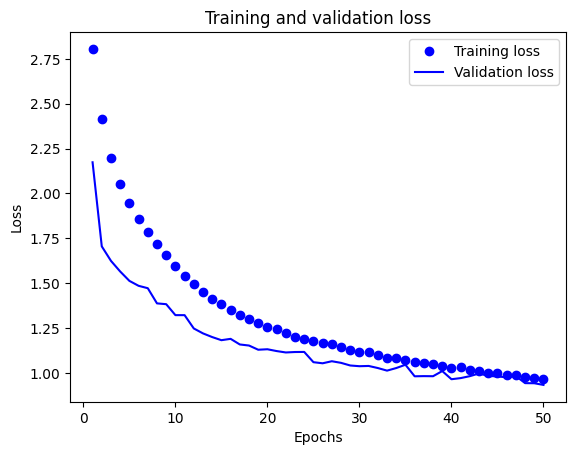

In [24]:
import numpy as np
import matplotlib.pyplot as plt
# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Training and validation accuracy curves

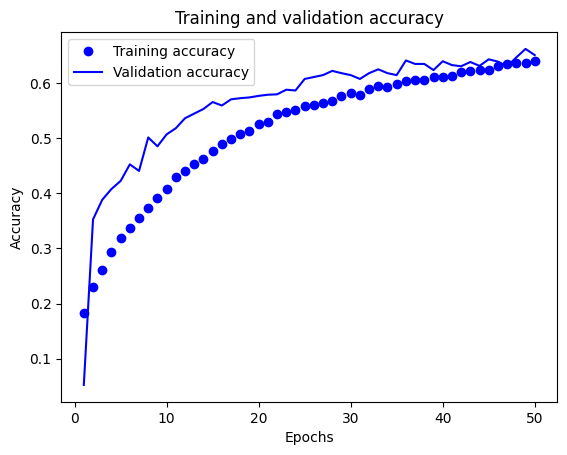

In [25]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion Matrix

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


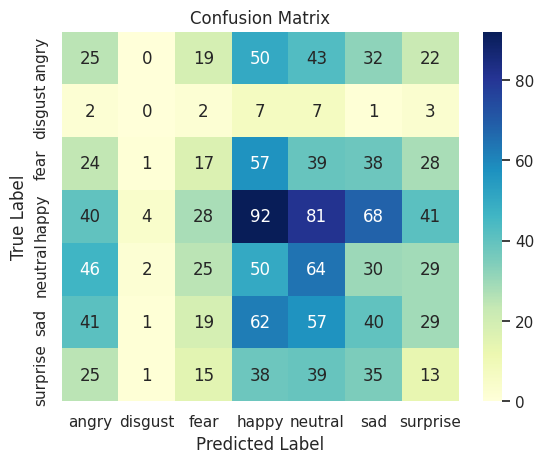

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()